In [1]:
import numpy as np
import json
import matplotlib.pyplot as plt
from eval_qa import eval_file
import matplotlib.colors as mcolors
import seaborn as sns

In [2]:
# replace with your actual training steps for the examined checkpoints
x = np.array([2000*i for i in range(1, 21)] + [50000 * (i+1) for i in range(100)])/1e5
x = x[:33]

In [3]:
with open("local_dir/counterfactual_comparison.json", "r", encoding='utf-8') as f:
    results = json.load(f)

def flatten(d):
    res = dict()
    for item in d:
        for key, val in item.items():
            if key not in res:
                res[key] = []
            res[key].append(val)
    return res

result_list = []
for item in results:
    temp = flatten(item)
    for key, val in temp.items():
        if "rank" in key:
            temp[key] = np.mean(1/(np.array(val)+1))    # MRR
        else:
            temp[key] = 1 - np.mean(np.array(val)==0)   # ACC
    result_list.append(temp)
result_dict = flatten(result_list)

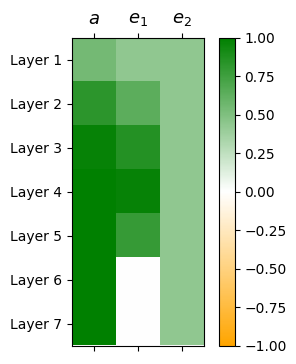

In [ ]:
mats = []
for i in range(33):
    mat = np.zeros([7, 3])
    for layer in range(7):
        for pos, pref in enumerate(["a", "e1", "e2"]):
            key = "{}_{}".format(pref, layer+1)
            val = result_dict[key][i]
            mat[layer, pos] = val
    mats.append(mat)
mats = np.array(mats)

mat = mats[-1] - mats[10]   # delta in causal strength

x_labels = ['Layer {}'.format(i) for i in range(1, 8)]
y_labels = ['$a$', '$e_1$', '$e_2$']

cmap = mcolors.LinearSegmentedColormap.from_list('orange_green', ['orange', 'white', 'green'], N=256)
norm = mcolors.TwoSlopeNorm(vmin=-1.0, vmax=1.0, vcenter=0)
fig, ax = plt.subplots(figsize=(5, 4))
cax = ax.matshow(mat, cmap=cmap, norm=norm)
cbar = fig.colorbar(cax, fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=10)
plt.yticks(range(mat.shape[0]), x_labels, fontsize=10)
plt.xticks(range(mat.shape[1]), y_labels, fontsize=13)
plt.show()

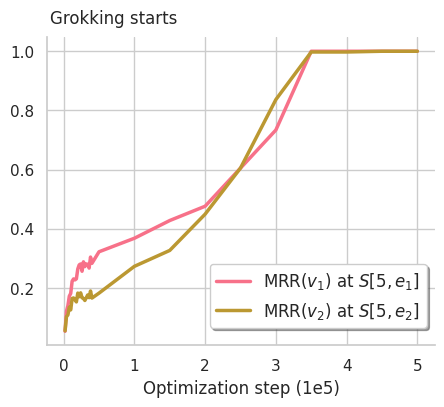

In [ ]:
sns.set(style="whitegrid")

plt.figure(figsize=(5,4))
ax = plt.subplot(111)
ax.spines[['right', 'top']].set_visible(False)

layer = 5

palette = sns.color_palette("husl", 6)

plt.plot(x[:-3], result_dict['val1_rank_pos2'+"_"+str(layer)][:-3], label='MRR($v_1$) at $S[5,e_1]$', color=palette[0], linewidth=2.5, zorder=2)
plt.plot(x[:-3], result_dict['val2_rank_pos4'+"_"+str(layer)][:-3], label='MRR($v_2$) at $S[5,e_2]$', color=palette[1], linewidth=2.5,  zorder=2)

plt.annotate('Grokking starts', xy=(0, 1), xytext=(-10, 20),
             textcoords='offset points',
             fontsize=12)

plt.legend(loc='lower right', bbox_to_anchor=(1.0,0.03), fancybox=True, shadow=True, ncol=1, fontsize=12)
plt.xlabel("Optimization step (1e5)")
plt.show()